In [1]:
Sys.setlocale(category = "LC_ALL", locale = "en_US.UTF-8")

[1] "en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/C"

# Dependencies

In [ ]:
colpal <- c("Vincristine" = "#E41A1C", 
           "Methotrexate" = "#377EB8",
           "Cyclophosphamide" = "#4DAF4A",
           "Vincristine/Methotrexate" = "#984EA3",
           "Vincristine/Cyclophosphamide" = "#fa9734",
           "Vincristine/Methotrexate/Cyclophosphamide" = "#f781bf",
           "No therapy" = "grey",
           "Others" = "#6c6c6c")



In [3]:
pacman::p_load(dplyr, ggplot2, ggbeeswarm, ggpubr, ggsignif, ggrepel, patchwork,
cowplot, ComplexHeatmap, factoextra, FactoMineR, VIM, missMDA, tidyr, stringr)

# Functions

In [6]:
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/Misc_functions.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/Plotting_functions.R")

# Paths

In [7]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [8]:
# h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

In [9]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))
soc_good <- readr::read_rds(paste0(datapath,"soc_good_with_baseregimen.rds"))

In [10]:
soc_good_long <- soc_good %>%
  pivot_longer(
    cols = starts_with("base_regimen_"),
    names_to = "cycle",
    values_to = "regimen",
    names_prefix = "base_regimen_"
  ) %>%
  select(Patient, cycle, regimen)


# Join soc_good_long to meta_div
# First, create a mapping between cycle formats (X05 -> cycle5)
meta_div$cycle_mapped <- paste0("cycle", gsub("X0?", "", meta_div$cycle))

# Join the datasets
meta_div <- meta_div %>%
  left_join(soc_good_long, by = c("Patient" = "Patient", "cycle_mapped" = "cycle"))

# Clean up the temporary column
 meta_div$cycle_mapped <- NULL


In [11]:
# Create soc_good_steroid by pivoting longer on cycle drug columns
soc_good_steroid <- soc_good %>%
  pivot_longer(
    cols = starts_with("Cycle") & ends_with("Drugs"),
    names_to = "cycle_info",
    values_to = "drugs"
  ) %>%
  # Extract cycle number from column names like "Cycle 1 Drugs", "Cycle 2 Drugs", etc.
  mutate(
    cycle = paste0("cycle", str_extract(cycle_info, "\\d+")),
    # Check if drugs contain dexamethasone or prednisolone
    has_steroid = case_when(
      is.na(drugs) ~ NA,
      str_detect(tolower(drugs), "dexamethasone|prednisolone|prednisone") ~ TRUE,
      TRUE ~ FALSE
    )
  ) %>%
  select(Patient, cycle, drugs, has_steroid)

# Join soc_good_steroid to meta_div
# First, create a mapping between cycle formats (X05 -> cycle5)
meta_div$cycle_mapped <- paste0("cycle", gsub("X0?", "", meta_div$cycle))

# Join the datasets
meta_div <- meta_div %>%
  left_join(soc_good_steroid, by = c("Patient" = "Patient", "cycle_mapped" = "cycle"))

# Clean up the temporary column
 meta_div$cycle_mapped <- NULL


In [12]:
head(meta_div)

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,basename,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen,drugs,has_steroid
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<chr>,<lgl>
1,CHP_319_05,CHP_319,X05,1.2,0.00,1,HR ALL,1.2,NA,NA,...,CHP_319-05-PBMC-DNA,batch2_Aug62019/mixcr/clones/CLONES_TRBCHP_319-05-PBMC-DNA.txt,PBMC,CHP,1.074759,CHP_319_05_PBMC,capTCR-seq,Vincristine/Methotrexate,"Vincristine, Prednisone, Mercaptopurine, Methotrexate *repeats until end of therapy",TRUE
2,CHP_323_03,CHP_323,X03,0.0,786.24,1,HR ALL,0.0,NA,NA,...,CHP_323-03-PBMC-DNA,batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_323-03-PBMC-DNA.txt,PBMC,CHP,1.576594,CHP_323_03_PBMC,capTCR-seq,Vincristine/Methotrexate,"Vincristine, Mercaptopurine, Methotrexate",FALSE
3,CHP_323_05,CHP_323,X05,0.0,979.50,1,HR ALL,0.0,NA,NA,...,CHP_323-05-PBMC-DNA,batch7_25Oct2019/mixcr/clones/CLONES_TRBCHP_323-05-PBMC-DNA.txt,PBMC,CHP,1.912506,CHP_323_05_PBMC,capTCR-seq,Vincristine/Methotrexate,"Vincristine, Prednisone, Mercaptopurine, Methotrexate *repeats until end of therapy",TRUE
4,CHP_324_05,CHP_324,X05,0.0,0.00,12,T-ALL,0.0,NA,NA,...,CHP_324-05_PBMC-DNA,remaining_batch_2_22April2021/mixcr/clones/CLONES_TRBCHP_324-05_PBMC-DNA.txt,PBMC,CHP,2.113672,CHP_324_05_PBMC,capTCR-seq,Others,N/A,FALSE
5,CHP_328_04,CHP_328,X04,0.0,130.82,7,SR ALL,0.0,NA,NA,...,CHP-328-04-PBMC-DNA,remaining_batch_4_28June2021/mixcr/clones/CLONES_TRBCHP-328-04-PBMC-DNA.txt,PBMC,CHP,2.349758,CHP_328_04_PBMC,capTCR-seq,Vincristine/Cyclophosphamide,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",TRUE
6,CHP_328_05,CHP_328,X05,0.0,91.16,7,SR ALL,0.0,NA,NA,...,CHP-328-05-PBMC-DNA,remaining_batch_4_28June2021/mixcr/clones/CLONES_TRBCHP-328-05-PBMC-DNA.txt,PBMC,CHP,1.941117,CHP_328_05_PBMC,capTCR-seq,Vincristine/Methotrexate,"Vincristine, Dexamethasone, Mercaptopurine, Methotrexate *repeats until end of therapy",TRUE


In [13]:
# Create exposed_regimen column, for each patient, if cycle is X01, then it is baseline, otherwise it is the previous cycle's regimen
## Use the soc_good dataframe to get the regimen for the previous cycle
## First, create a mapping between cycle formats (X05 -> cycle5)
## be explicit, eg get regimen of X04 for exponsed_regimen of X05
# Create exposed_regimen column
meta_div$exposed_regimen <- NA

# For each sample, determine the exposed regimen
for (i in 1:nrow(meta_div)) {
  current_patient <- meta_div$Patient[i]
  current_cycle <- meta_div$cycle[i]
  
  # If it's X01 (first cycle), exposed_regimen is NA (baseline)
  if (current_cycle == "X01") {
    meta_div$exposed_regimen[i] <- "baseline"
  } else {
    # Extract cycle number and get previous cycle
    cycle_num <- as.numeric(gsub("X0?", "", current_cycle))
    prev_cycle_num <- cycle_num - 1
    
    # Format previous cycle (e.g., 4 -> "cycle4")
    prev_cycle_col <- paste0("cycle", prev_cycle_num)
    
    # Get the base regimen for the previous cycle from soc_good
    prev_regimen <- as.character(soc_good[soc_good$Patient == current_patient, paste0("base_regimen_", prev_cycle_col), drop = T])
    
    if (length(prev_regimen) > 0 && !is.na(prev_regimen)) {
      meta_div$exposed_regimen[i] <- prev_regimen
    }
  }
}



In [14]:
meta_div_pbmc <- meta_div[ meta_div$sampletype == "PBMC",]
meta_div_cfdna <- meta_div[ meta_div$sampletype == "cfDNA",]

In [15]:
head(soc_good[ soc_good$`Patient ID` == "407", ])

Patient ID,Diagnosis,Cycle 1 Type,Cycle 1 Drugs,Cycle 1 Duration (days),Cycle 1 Steroids,Cycle 2 Type,Cycle 2 Drugs,Cycle 2 Duration (days),Cycle 2 Steroids,...,base_regimen_cycle2,base_regimen_cycle3,base_regimen_cycle4,base_regimen_cycle5,cycle1exist,cycle2exist,cycle3exist,cycle4exist,cycle5exist,Patient
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
407,DLBCL,Prephase,"Vincristine, Cyclophosphamide, Prednisone",7,Yes,Induction,"Vincristine, Cyclophosphamide, Prednisone, Doxorubicin, Methotrexate",21,Yes,...,Vincristine/Methotrexate/Cyclophosphamide,Methotrexate,Methotrexate,Others,Yes,Yes,Yes,Yes,Yes,CHP_407


In [16]:
meta_div_pbmc$cfShannon <- meta_div_cfdna$observed_Shannon[match(meta_div_pbmc$sample_id, meta_div_cfdna$sample_id)]

## PCA

In [17]:
cols_flow <- c('ATC', 'Naïve%','SCM%','CM%','EM%','TE%','PD1%','LAG3%','TIM3%')
cols_others <- c("observed_Shannon", "cfShannon")

In [18]:
meta_div_pbmc$cyclenum <- as.numeric(gsub("X0", "", meta_div_pbmc$cycle))

In [19]:
mymat <- meta_div_pbmc[, c(cols_flow, cols_others)]

In [20]:
rownames(mymat) <- meta_div_pbmc[["sample_id"]]
# remove rows with all NAs
mymat <- mymat[rowSums(is.na(mymat)) != ncol(mymat), ]
# rmeove those with only 0s and NAs
mymat <- mymat[rowSums(mymat, na.rm = TRUE) != 0, ]

In [21]:
# meta_div_pbmc <- meta_div_pbmc[meta_div_pbmc$sample_id %in% rownames(mymat), ]

In [22]:
mymat_narm <- mymat[rowSums(is.na(mymat)) == 0, ]

In [23]:
# myvars <- sort(Rfast::colVars(mymat_narm), decreasing = TRUE)
# mymat_narm <- mymat_narm[, names(myvars)[myvars > 0]]

In [24]:
df_narm <- meta_div_pbmc[ meta_div_pbmc$sample_id %in% rownames(mymat_narm), ]

In [25]:
head(meta_div_pbmc)

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,Group,log10shann,sample_id_sampletype,assay,regimen,drugs,has_steroid,exposed_regimen,cfShannon,cyclenum
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<chr>,<dbl>,<chr>,<chr>,<fct>,<chr>,<lgl>,<chr>,<dbl>,<dbl>
1,CHP_319_05,CHP_319,X05,1.2,0.00,1,HR ALL,1.2,NA,NA,...,CHP,1.074759,CHP_319_05_PBMC,capTCR-seq,Vincristine/Methotrexate,"Vincristine, Prednisone, Mercaptopurine, Methotrexate *repeats until end of therapy",TRUE,Vincristine/Cyclophosphamide,NA,5
2,CHP_323_03,CHP_323,X03,0.0,786.24,1,HR ALL,0.0,NA,NA,...,CHP,1.576594,CHP_323_03_PBMC,capTCR-seq,Vincristine/Methotrexate,"Vincristine, Mercaptopurine, Methotrexate",FALSE,Vincristine/Cyclophosphamide,43.423179,3
3,CHP_323_05,CHP_323,X05,0.0,979.50,1,HR ALL,0.0,NA,NA,...,CHP,1.912506,CHP_323_05_PBMC,capTCR-seq,Vincristine/Methotrexate,"Vincristine, Prednisone, Mercaptopurine, Methotrexate *repeats until end of therapy",TRUE,Vincristine/Cyclophosphamide,8.670523,5
4,CHP_324_05,CHP_324,X05,0.0,0.00,12,T-ALL,0.0,NA,NA,...,CHP,2.113672,CHP_324_05_PBMC,capTCR-seq,Others,N/A,FALSE,Vincristine/Cyclophosphamide,1.774633,5
5,CHP_328_04,CHP_328,X04,0.0,130.82,7,SR ALL,0.0,NA,NA,...,CHP,2.349758,CHP_328_04_PBMC,capTCR-seq,Vincristine/Cyclophosphamide,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",TRUE,Vincristine/Methotrexate,NA,4
6,CHP_328_05,CHP_328,X05,0.0,91.16,7,SR ALL,0.0,NA,NA,...,CHP,1.941117,CHP_328_05_PBMC,capTCR-seq,Vincristine/Methotrexate,"Vincristine, Dexamethasone, Mercaptopurine, Methotrexate *repeats until end of therapy",TRUE,Vincristine/Cyclophosphamide,3.064842,5


In [26]:
dim(df_narm)

[1] 75 74

In [27]:
table(df_narm$Relapse)


 0  1 
61 14 

In [28]:
dim(mymat_narm)

[1] 75 11

In [29]:
dim(mymat)

[1] 326  11

In [30]:
# # Get median of mymat_narm columns for each cancergroup using df_narm
# medians <- apply(mymat_narm, 2, function(x) tapply(x, df_narm$cancergroup, median, na.rm = TRUE))
# mads <- apply(mymat_narm, 2, function(x) tapply(x, df_narm$cancergroup, mad, na.rm = TRUE))

In [31]:
# scale each column by the median of the cancergroup in medians
# mymat_narm_scaled <- mymat_narm
# for(i in 1:nrow(mymat_narm)){
#   mymat_narm_scaled[i, ] <- mymat_narm[i, ]/medians[df_narm$cancergroup[i], ]#/ mads[df_narm$cancergroup[i], ]
# }

In [32]:
colnames(mymat_narm)[colnames(mymat_narm) == "observed_Shannon"] <- "TCR Diversity"
colnames(mymat_narm)[colnames(mymat_narm) == "cfShannon"] <- "cfTCR Diversity"

In [33]:
set.seed(123)
pca <- prcomp(mymat_narm, center = T, scale. = T)

In [34]:
# Print percentage variance explained by PC1-5
summary(pca)$importance[2, 1:5] * 100


PC1    PC2    PC3    PC4    PC5 
31.945 20.030 10.077  9.838  9.193

In [35]:
p1 <- fviz_pca_ind(pca,
     col.ind = as.vector(df_narm$cancergroup),
    # gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
    # remove labels
    label = "none",
    repel = TRUE, addEllipses = FALSE, mean.point = FALSE
)

In [36]:
# flip the first PC
# pca$rotation[,1] <- -pca$rotation[,1]

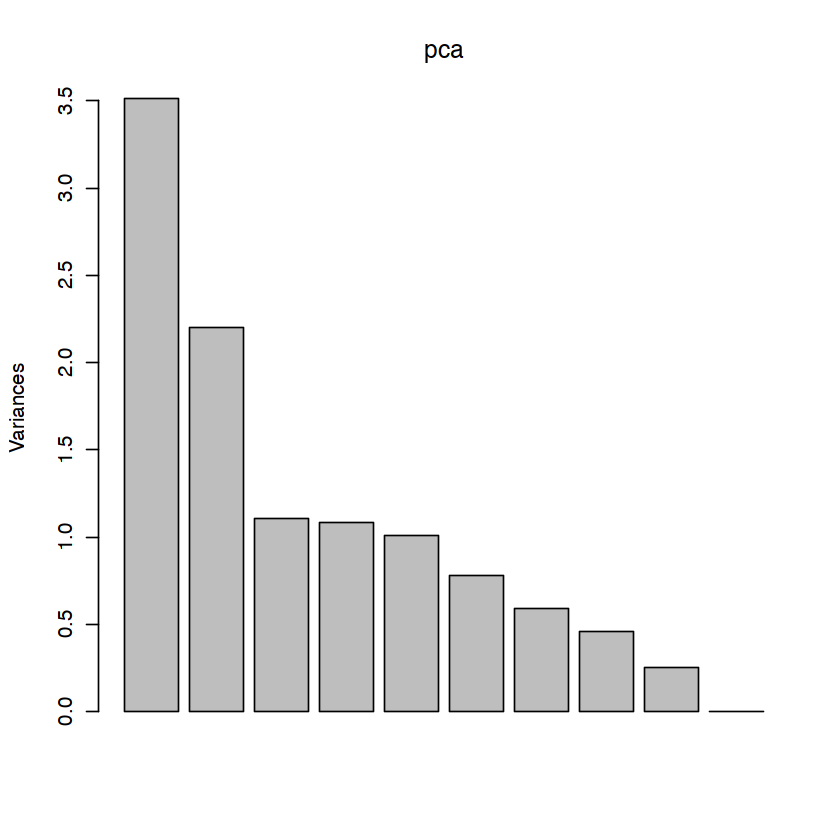

In [37]:
screeplot(pca)

varplot

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”


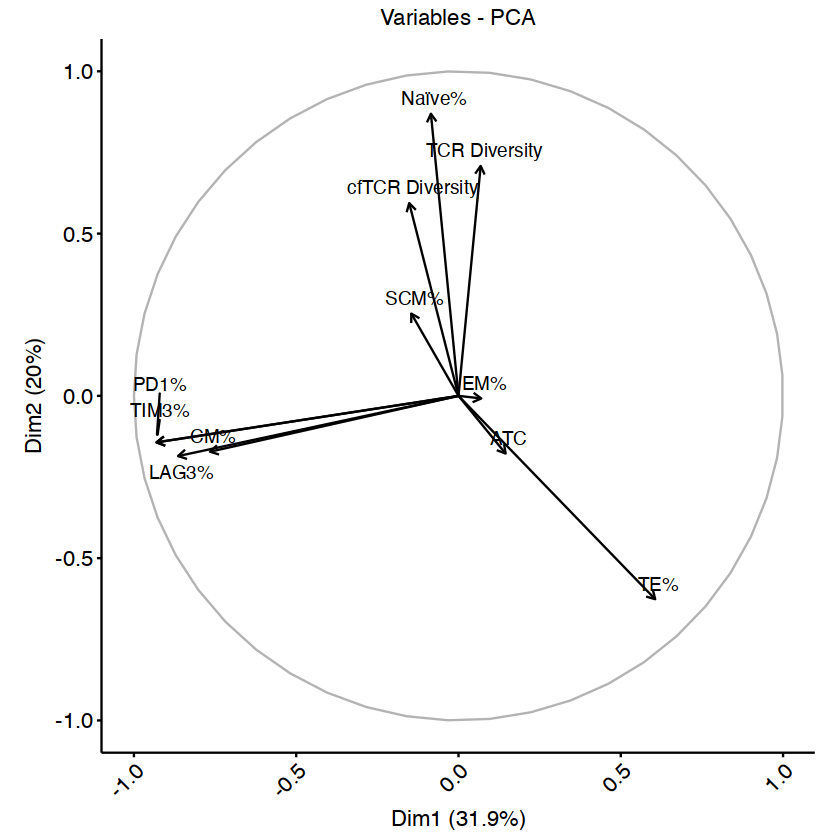

In [38]:
p2 <- fviz_pca_var(pca, repel = F, geom = "arrow", axes.linetype = NA) +
    geom_text_repel(aes(label = rownames(pca$rotation)),
        point.padding = unit(0.5, "lines"),
        min.segment.length = unit(0, "lines"),
        nudge_x = 0.01, nudge_y = 0.01,
        direction = "y"
    ) + myaxis + myplot

p2

In [39]:
pdf(paste0(plotpath, "PCAvarplot.pdf"), width = 7, height = 7)
p2
dev.off()


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”


pdf 
  2

biplot

In [40]:
df_narm$prepost <- NA
df_narm$prepost[ df_narm$cycle == "X01"] <- "Pre-therapy"
df_narm$prepost[ df_narm$cycle != "X01"] <- "Post-therapy"

In [41]:
names(colpal)

[1] "Vincristine"                              
[2] "Methotrexate"                             
[3] "Cyclophosphamide"                         
[4] "Vincristine/Methotrexate"                 
[5] "Vincristine/Cyclophosphamide"             
[6] "Vincristine/Methotrexate/Cyclophosphamide"
[7] "Others"

In [42]:
colpal <- c("baseline" = "black", colpal)

In [43]:
# Factor exposed_regimen with baseline first and Others last
df_narm$exposed_regimen <- factor(df_narm$exposed_regimen, 
                                  levels = names(colpal))
table(df_narm$exposed_regimen)


                                 baseline 
                                       24 
                              Vincristine 
                                        9 
                             Methotrexate 
                                       11 
                         Cyclophosphamide 
                                        2 
                 Vincristine/Methotrexate 
                                        3 
             Vincristine/Cyclophosphamide 
                                       15 
Vincristine/Methotrexate/Cyclophosphamide 
                                        1 
                                   Others 
                                       10 

In [44]:
p3 <- fviz_pca_biplot(pca,
    geom.var = c("arrow", "text"),
    geom.ind = "point",
    alpha.ind = 0, alpha.var = 1,
    # col.ind = df_narm$cancergroup,
    # shape.ind = df_narm$prepost,
    col.var = "black",
    repel = TRUE,
    labelsize = 6,
    arrowsize = 0.5,
    addEllipses = FALSE, 
    mean.point = FALSE,
    title = "") +
    geom_point(aes(colour = df_narm$exposed_regimen), size = 4, alpha = 0.5, shape = 16) +
    scale_color_manual(values = colpal) + myplot + myaxis +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5, size = 20), 
    axis.text.y = element_text(size = 20),
    axis.title = element_text(size = 20)) +
    scale_x_continuous(limits=c(-6,3)) + scale_y_continuous(limits=c(-3,4))
# increase size of the legends
p3 <- p3 + theme(legend.text = element_text(size = 10), legend.title = element_text(size = 10))
p3 <- p3 + labs(x = "Inverted Immune Checkpoint axis\n(PC1 = 31.9%)", y = "Diversity axis\n(PC2 = 20%)")

In [45]:
pdf(paste0(plotpath, "PCAbiplot_colorby_regimen.pdf"), width = 7, height = 7)
cowplot::plot_grid(p3 + theme(legend.position = "none"), labels = "A")
dev.off()

pdf 
  2

In [46]:
pdf(paste0(plotpath, "PCAbiplot_lgd_regimen.pdf"), width = 5, height = 5)
grid.draw(get_legend(p3 + theme(legend.background = element_blank(), legend.position = "right") + labs(colour = "Regimen")) )
dev.off()

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


pdf 
  2

indplot

In [47]:
df_narm$Dim1 <- pca$x[,1][match( df_narm$sample_id, rownames(pca$x))]
df_narm$Dim2 <- pca$x[,2][match( df_narm$sample_id, rownames(pca$x))]

In [48]:
# indplot <- ggplot(df_narm, aes(x = Dim1, y = Dim2)) +
#     geom_hline(yintercept = 0, linetype = "dashed", color = "gray50") +
#     geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
#     geom_point(aes(colour = exposed_regimen), size = 4, alpha = 0.5) +
#     myplot + myaxis +
#     scale_color_manual(values = c(colpal, "baseline" = "black")) +
#     theme(axis.text.x = element_text(angle = 0, hjust = 0.5, size = 20), 
#     axis.text.y = element_text(size = 20),
#     axis.title = element_text(size = 20)) +
#     theme(legend.text = element_text(size = 8), legend.title = element_blank(), legend.position = "right") +
#     labs(x = "Inverted Immune Checkpoint axis\n(PC1 = 31.9%)", y = "Diversity axis\n(PC2 = 20%)") + facet_wrap(~cancergroup, scales = "free") +
#     theme(
#         #axis.title.x = element_blank(),
#         #legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside",
#         axis.line = element_line()
#     ) + scale_x_continuous(limits=c(-6,3)) + scale_y_continuous(limits=c(-3,4))
# indplot


In [49]:
# pdf(paste0(plotpath, "PCA_facet_cancergroups_regimen.pdf"), width = 8, height = 8)
# indplot + theme(legend.position = "none")
# dev.off()


In [50]:
# Factor Disease_type to match cancergroup order
df_narm$Disease_type <- factor(df_narm$Disease_type, 
                              levels = c("ALL", "AML", "CML", "HR ALL",  # Leukemia
                                        "BL", "DLBCL", "HD", "PMBCL",    # Lymphoma  
                                        "ARMS", "ERMS", "EWS", "HB", "NB", "OS", "WILMS",  # Solid tumors
                                        "ALCL", "T-ALL"))  # T-cell malignancies


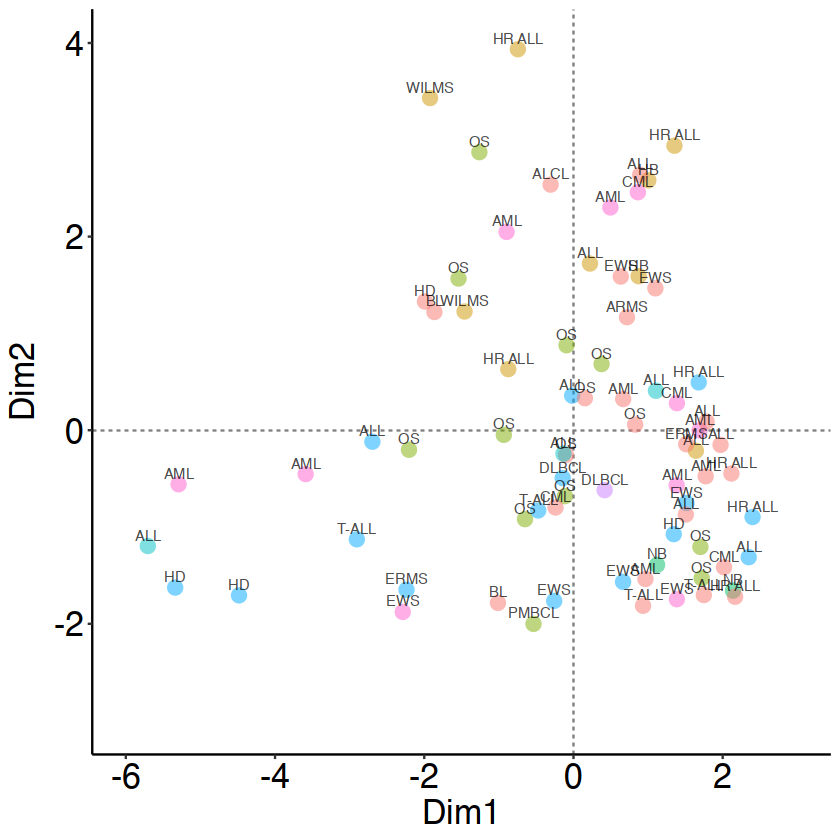

In [51]:
ggplot(df_narm, aes(x = Dim1, y = Dim2)) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray50") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
    geom_point(aes(colour = exposed_regimen), size = 4, alpha = 0.5, shape = 16) +
    myplot + myaxis +
    geom_text(aes(label = Disease_type), size = 3, alpha = 0.7, vjust = -0.5) +

    theme(axis.text.x = element_text(angle = 0, hjust = 0.5, size = 20), 
    axis.text.y = element_text(size = 20),
    axis.title = element_text(size = 20)) +
    theme(legend.text = element_text(size = 8), legend.title = element_text(size = 8), legend.position = "none") +
    scale_x_continuous(limits=c(-6,3)) + scale_y_continuous(limits=c(-3,4))

In [52]:
# with placeholders
df_narm$Disease_type <- factor(df_narm$Disease_type, 
                              levels = c("ALL", "AML", "CML", "HR ALL", # Leukemia
                                        "BL", "DLBCL", "HD", "PMBCL",    # Lymphoma  
                                        "ARMS", "ERMS", "EWS", "HB", "NB", "OS", "WILMS", " ",  # Solid tumors
                                        "ALCL", "T-ALL"))  # T-cell malignancies

In [53]:
# indplot <- ggplot(df_narm, aes(x = Dim1, y = Dim2)) +
#     geom_hline(yintercept = 0, linetype = "dashed", color = "gray50") +
#     geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
#     geom_point(aes(colour = exposed_regimen), size = 4, alpha = 0.5, shape = 16) +
#     myplot + myaxis +
#     scale_color_manual(values = colpal) +
#     theme(axis.text.x = element_text(angle = 0, hjust = 0.5, size = 20), 
#     axis.text.y = element_text(size = 20),
#     axis.title = element_text(size = 20)) +
#     theme(legend.text = element_text(size = 8), legend.title = element_text(size = 8), legend.position = "right") +
#     labs(x = "Inverted Immune Checkpoint axis\n(PC1 = 31.9%)", y = "Diversity axis\n(PC2 = 20%)") + 
#     facet_wrap(~Disease_type, scales = "free", ncol = 4, nrow = 5, drop = FALSE) +
#     theme(
#         #axis.title.x = element_blank(),
#         #legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside",
#         axis.line = element_line()
#     ) + scale_x_continuous(limits=c(-6,3)) + scale_y_continuous(limits=c(-3,4))
# indplot

In [58]:
baseplot <- ggplot(df_narm, aes(x = Dim1, y = Dim2)) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray50") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
    geom_point(aes(colour = exposed_regimen), size = 4, alpha = 0.5, shape = 16) +
    myplot + myaxis +
    scale_color_manual(values = colpal) +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5, size = 20), 
    axis.text.y = element_text(size = 20),
    axis.title = element_text(size = 20)) +
    theme(legend.text = element_text(size = 8), legend.title = element_text(size = 8), legend.position = "right") +
    labs(x = "Inverted Immune Checkpoint axis\n(PC1 = 31.9%)", y = "Diversity axis\n(PC2 = 20%)") + 
    ggh4x::facet_manual(~ Disease_type, design, scales = "free") +
   # facet_wrap(~Disease_type, scales = "free", ncol = 4, nrow = 5, drop = FALSE) +
    theme(
        #axis.title.x = element_blank(),
        #legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside",
        axis.line = element_line()
    ) + 
    scale_x_continuous(limits=c(-6,3)) + scale_y_continuous(limits=c(-3,4))


In [57]:
design <- "
 ABCD
 EFGH
 IJKL
 MNO#
 PQ##
"

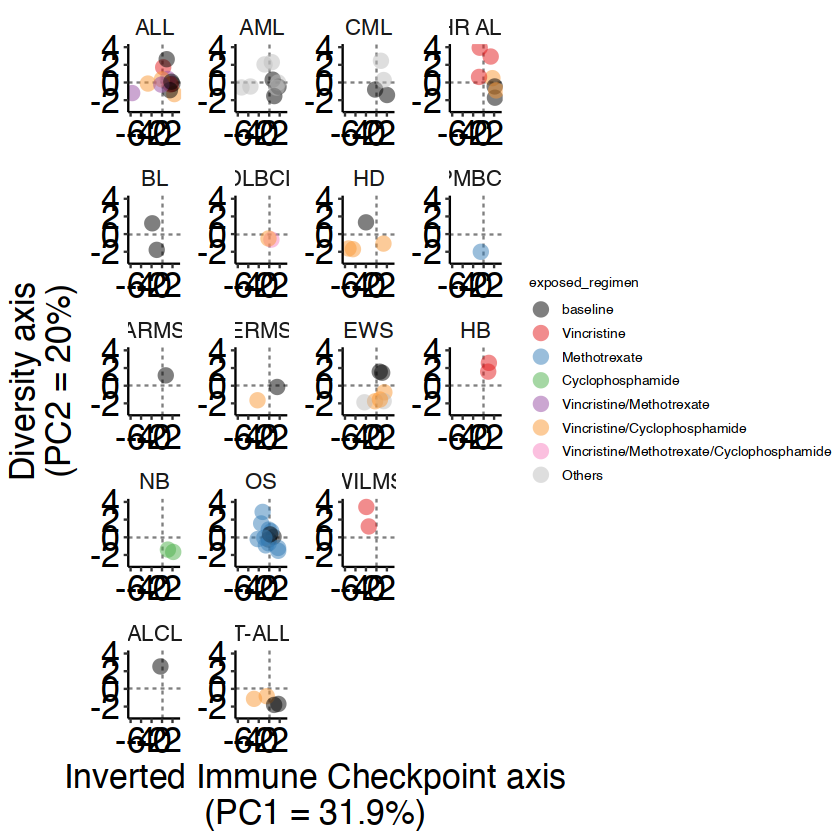

In [59]:
baseplot #+ ggh4x::facet_manual(~ Disease_type, design)

In [183]:
pdf(paste0(plotpath, "PCA_facet_disease_regimen.pdf"), width = 12, height = 12)
plot_grid(baseplot + theme(legend.position = "none"), labels = "B")
dev.off()

pdf 
  2

$baseline
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.99052  0.08997  0.91324  0.74858  1.75348  2.16630 

$Vincristine
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.92228 -0.87370  0.22089  0.01014  1.00307  1.64124 

$Methotrexate
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.2046 -1.0973 -0.5355 -0.3215  0.1416  1.7185 

$Cyclophosphamide
NULL

$`Vincristine/Methotrexate`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.7049 -2.9197 -0.1344 -1.5780  0.4855  1.1054 

$`Vincristine/Cyclophosphamide`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.3384 -2.4667 -0.1445 -0.5733  1.4292  2.4005 

$`Vincristine/Methotrexate/Cyclophosphamide`
NULL

$Others
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.2931 -1.9403  0.6791 -0.4863  1.3853  1.6902 


[1] "t-test results for PC1 (Dim1): Each regimen vs. baseline (excluding regimens with <= 2 cases):"
                       regimen            p.value          mean.diff
1 Vincristine/Cyclophosphamide 0.0655267499554503  -1.32189434248139
2                       Others  0.157304654949985  -1.23489787574702
3                  Vincristine  0.159458373047363 -0.738443196946142
4     Vincristine/Methotrexate  0.382227859517105  -2.32657240995605
5                 Methotrexate 0.0263915936531178  -1.07011620337446


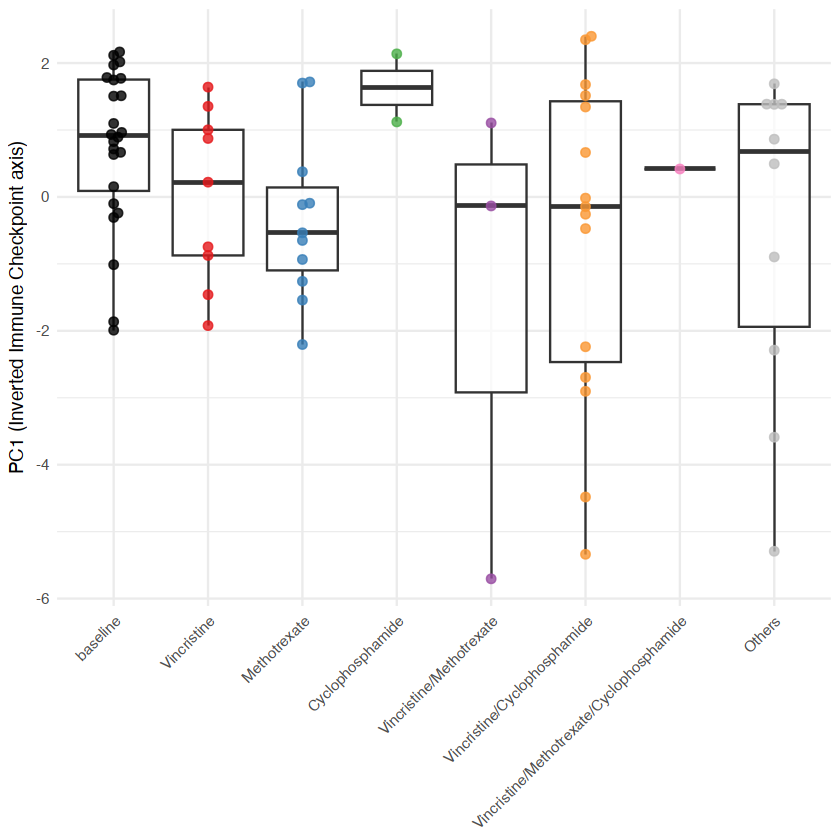

In [69]:
# Create boxplot and beeswarm plot for Dim1 by regimen
p1 <- ggplot(df_narm, aes(x = exposed_regimen, y = Dim1)) +
    geom_boxplot(alpha = 0.7, outlier.shape = NA) +
    geom_beeswarm(aes(color = exposed_regimen), size = 2, alpha = 0.8) +
    labs(x = "Regimen", y = "PC1 (Inverted Immune Checkpoint axis)") +
    theme_minimal() + scale_color_manual(values = c(colpal, "baseline" = "black")) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.title.x = element_blank(),
          legend.position = "none")

# Create boxplot and beeswarm plot for Dim2 by regimen
p2 <- ggplot(df_narm, aes(x = exposed_regimen, y = Dim2)) +
    geom_boxplot(alpha = 0.7, outlier.shape = NA) +
    geom_beeswarm(aes(color = exposed_regimen), size = 2, alpha = 0.8) +
    labs(x = "Regimen", y = "PC2 (Diversity axis)") +
    theme_minimal() + scale_color_manual(values = c(colpal, "baseline" = "black")) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.title.x = element_blank(),
          legend.position = "none")

# Display plots
p1

# Filter out regimens with <= 2 cases
regimen_counts <- table(df_narm$exposed_regimen)
regimens_to_keep <- names(regimen_counts[regimen_counts > 2])
df_filtered <- df_narm[df_narm$exposed_regimen %in% regimens_to_keep, ]

tapply(df_filtered$Dim1, df_filtered$exposed_regimen, summary, na.rm = TRUE)
# Perform pairwise tests for Dim1 (excluding regimens with <= 2 cases)
# Compare all exposed_regimen groups to 'baseline' for PC1 (Dim1)
baseline_vs_other <- lapply(
  setdiff(unique(df_filtered$exposed_regimen), "baseline"),
  function(reg) {
    group1 <- df_filtered$Dim1[df_filtered$exposed_regimen == "baseline"]
    group2 <- df_filtered$Dim1[df_filtered$exposed_regimen == reg]
    if (length(group2) > 2) { # ensure at least 3 in the comparison group
      t_res <- t.test(group2, group1)
      c(regimen = reg,
        p.value = t_res$p.value,
        mean.diff = mean(group2, na.rm = TRUE) - mean(group1, na.rm = TRUE))
    } else {
      c(regimen = reg, p.value = NA, mean.diff = NA)
    }
  }
)
baseline_vs_other_df <- as.data.frame(do.call(rbind, baseline_vs_other))
print("t-test results for PC1 (Dim1): Each regimen vs. baseline (excluding regimens with <= 2 cases):")
print(baseline_vs_other_df)


In [70]:
tapply(df_filtered$Dim2, df_filtered$exposed_regimen, summary, na.rm = TRUE)
# Perform pairwise tests for Dim2 (excluding regimens with <= 2 cases)
# Compare all exposed_regimen groups to 'baseline' for PC1 (Dim2)
baseline_vs_other <- lapply(
  setdiff(unique(df_filtered$exposed_regimen), "baseline"),
  function(reg) {
    group1 <- df_filtered$Dim2[df_filtered$exposed_regimen == "baseline"]
    group2 <- df_filtered$Dim2[df_filtered$exposed_regimen == reg]
    if (length(group2) > 2) { # ensure at least 3 in the comparison group
      t_res <- t.test(group2, group1)
      c(regimen = reg,
        p.value = t_res$p.value,
        mean.diff = mean(group2, na.rm = TRUE) - mean(group1, na.rm = TRUE))
    } else {
      c(regimen = reg, p.value = NA, mean.diff = NA)
    }
  }
)
baseline_vs_other_df <- as.data.frame(do.call(rbind, baseline_vs_other))
print("t-test results for PC2 (Dim2): Each regimen vs. baseline (excluding regimens with <= 2 cases):")
print(baseline_vs_other_df)

$baseline
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.81349 -1.00713 -0.14815 -0.01559  1.18077  2.63731 

$Vincristine
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.2122  1.2263  1.7216  1.9827  2.9391  3.9357 

$Methotrexate
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.00089 -1.06258 -0.20221 -0.05337  0.78038  2.87234 

$Cyclophosphamide
NULL

$`Vincristine/Methotrexate`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.19651 -0.71971 -0.24292 -0.34396  0.08231  0.40753 

$`Vincristine/Cyclophosphamide`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.7631 -1.5960 -1.0741 -0.9375 -0.6234  0.4941 

$`Vincristine/Methotrexate/Cyclophosphamide`
NULL

$Others
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.8776 -0.5666 -0.2274  0.1880  1.6059  2.4582 


[1] "t-test results for PC2 (Dim2): Each regimen vs. baseline (excluding regimens with <= 2 cases):"
                       regimen             p.value           mean.diff
1 Vincristine/Cyclophosphamide 0.00878715496616013  -0.921933891029421
2                       Others   0.727000540078201   0.203561360994528
3                  Vincristine  0.0019230873887139     1.9982495669397
4     Vincristine/Methotrexate   0.579836737493229  -0.328379159505976
5                 Methotrexate   0.942475185655053 -0.0377805130061618


In [67]:
tapply(df_filtered$Dim2, df_filtered$exposed_regimen, summary, na.rm = TRUE)

$baseline
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.81349 -1.00713 -0.14815 -0.01559  1.18077  2.63731 

$Vincristine
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.2122  1.2263  1.7216  1.9827  2.9391  3.9357 

$Methotrexate
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.00089 -1.06258 -0.20221 -0.05337  0.78038  2.87234 

$Cyclophosphamide
NULL

$`Vincristine/Methotrexate`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.19651 -0.71971 -0.24292 -0.34396  0.08231  0.40753 

$`Vincristine/Cyclophosphamide`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.7631 -1.5960 -1.0741 -0.9375 -0.6234  0.4941 

$`Vincristine/Methotrexate/Cyclophosphamide`
NULL

$Others
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.8776 -0.5666 -0.2274  0.1880  1.6059  2.4582 


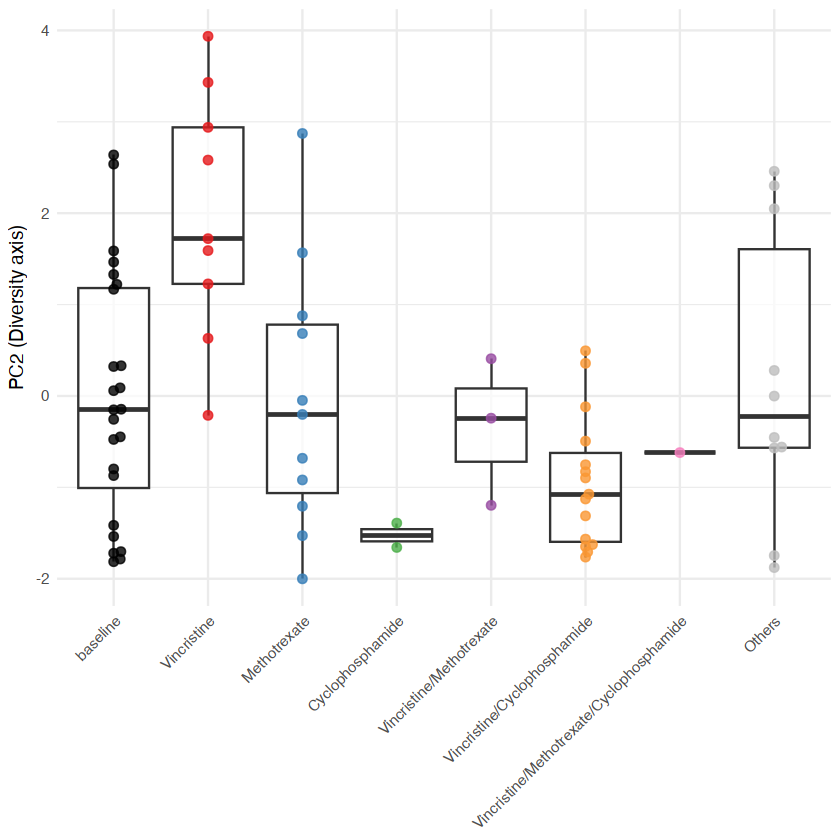

In [63]:
p2

In [77]:
# Fit a linear model to test association of Dim2 with exposed_regimen, adjusting for Disease_type
lm_dim1 <- lm(Dim1 ~ exposed_regimen + Disease_type, data = df_filtered)
summary_lm_dim1 <- summary(lm_dim1)
print("Linear model results for PC2 (Dim2) ~ exposed_regimen + Disease_type:")
coef_tbl <- broom::tidy(lm_dim1, conf.int = TRUE) 
print(coef_tbl)


[1] "Linear model results for PC2 (Dim2) ~ exposed_regimen + Disease_type:"
# A tibble: 21 × 7
   term                  estimate std.error statistic p.value conf.low conf.high
   <chr>                    <dbl>     <dbl>     <dbl>   <dbl>    <dbl>     <dbl>
 1 (Intercept)              1.68      0.699    2.40    0.0200    0.276    3.08  
 2 exposed_regimenVincr…   -1.72      1.03    -1.66    0.102    -3.79     0.354 
 3 exposed_regimenMetho…   -0.593     1.17    -0.509   0.613    -2.93     1.75  
 4 exposed_regimenVincr…   -3.26      1.24    -2.63    0.0113   -5.74    -0.769 
 5 exposed_regimenVincr…   -1.34      0.694   -1.93    0.0593   -2.73     0.0547
 6 exposed_regimenOthers   -1.57      0.852   -1.84    0.0719   -3.28     0.145 
 7 Disease_typeAML         -0.946     1.05    -0.899   0.373    -3.06     1.17  
 8 Disease_typeCML          0.112     1.19     0.0942  0.925    -2.27     2.50  
 9 Disease_typeHR ALL       0.597     0.916    0.652   0.518    -1.24     2.44  
10 Disease_typ

In [76]:
# Fit a linear model to test association of Dim2 with exposed_regimen, adjusting for Disease_type
lm_dim2 <- lm(Dim2 ~ exposed_regimen + Disease_type, data = df_filtered)
summary_lm_dim2 <- summary(lm_dim2)
print("Linear model results for PC2 (Dim2) ~ exposed_regimen + Disease_type:")
coef_tbl <- broom::tidy(lm_dim2, conf.int = TRUE) 
print(coef_tbl)

[1] "Linear model results for PC2 (Dim2) ~ exposed_regimen + Disease_type:"
# A tibble: 21 × 7
   term                  estimate std.error statistic p.value conf.low conf.high
   <chr>                    <dbl>     <dbl>     <dbl>   <dbl>    <dbl>     <dbl>
 1 (Intercept)             0.0915     0.525     0.174  0.862   -0.962      1.14 
 2 exposed_regimenVincr…   1.65       0.775     2.14   0.0375   0.0992     3.21 
 3 exposed_regimenMetho…   0.0971     0.876     0.111  0.912   -1.66       1.86 
 4 exposed_regimenVincr…  -0.435      0.930    -0.468  0.642   -2.30       1.43 
 5 exposed_regimenVincr…  -0.665      0.521    -1.28   0.208   -1.71       0.382
 6 exposed_regimenOthers   0.375      0.640     0.586  0.561   -0.910      1.66 
 7 Disease_typeAML        -0.222      0.790    -0.281  0.780   -1.81       1.36 
 8 Disease_typeCML        -0.148      0.893    -0.166  0.869   -1.94       1.64 
 9 Disease_typeHR ALL      0.0941     0.688     0.137  0.892   -1.29       1.48 
10 Disease_typ

In [ ]:
# # Save plots as PDF
# pdf(paste0(plotpath,"PCA_regimen_boxplots.pdf"), width = 10, height = 6)

# cowplot::plot_grid(p1 , p2, labels = c("C", "D"))
# dev.off()

pdf 
  2

Add ridges

Picking joint bandwidth of 0.948

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


Picking joint bandwidth of 0.563

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


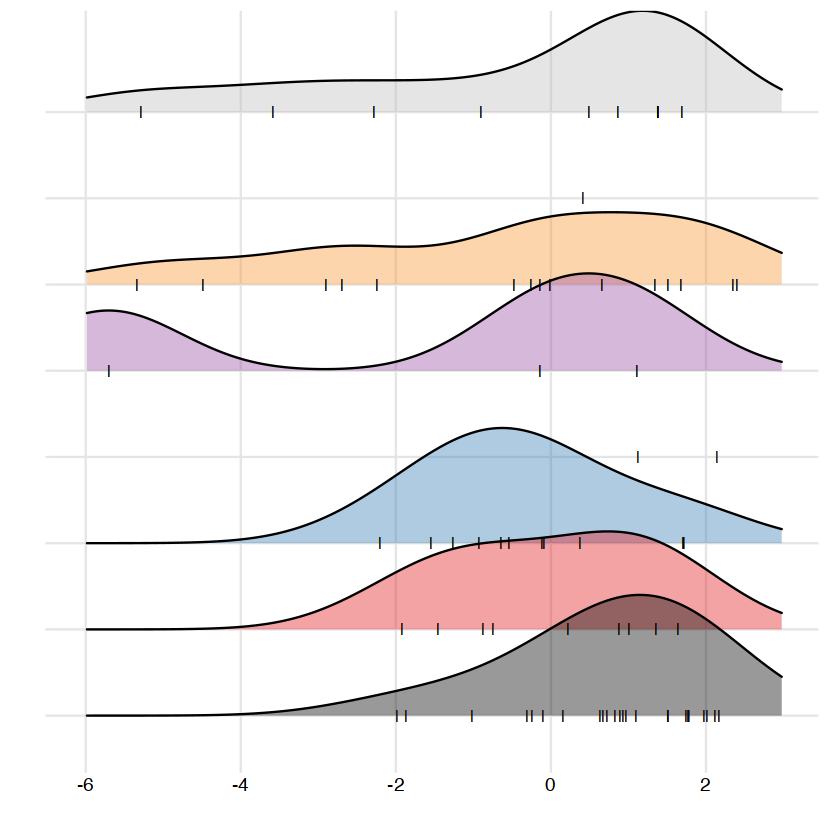

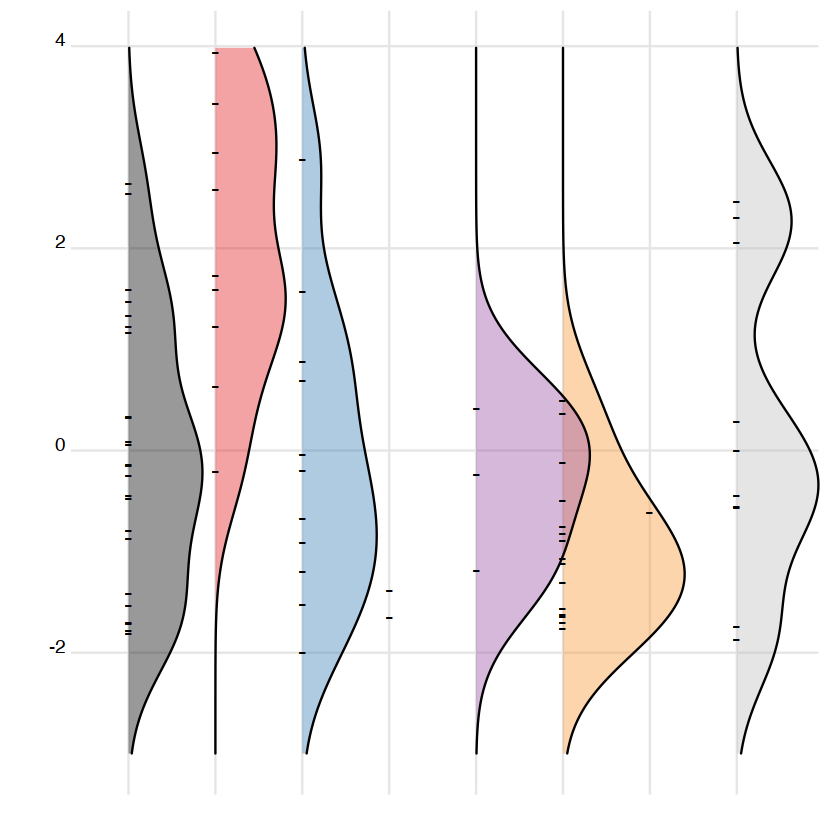

In [131]:
# Create ridge plots for PC1 and PC2 by regimen
library(ggridges)

# Ridge plot for PC1 (x-axis)
ridge_x <- ggplot(df_narm, aes(x = Dim1, y = exposed_regimen, fill = exposed_regimen, point_color = exposed_regimen)) +
  geom_density_ridges(
    alpha = 0.4,
    scale = 1,
    panel_scaling = TRUE,
    quantile_lines = FALSE, 
    jittered_points = TRUE, point_shape = "|", point_size = 3, 
    position = position_points_jitter(height = 0)
  ) +
  geom_point(shape="|", size = 3) +
  scale_fill_manual(values = colpal) +
  scale_color_manual(values = colpal) +
  labs(x = "", y = "") +
  theme_ridges(font_size = 13, grid = TRUE) +
  theme(legend.position = "none", axis.text.y = element_blank()) + scale_x_continuous(limits = c(-6, 3))

# Ridge plot for PC2 (y-axis) - rotated
ridge_y <- ggplot(df_narm, aes(x = Dim2, y = exposed_regimen, fill = exposed_regimen, point_color = exposed_regimen)) +
  geom_density_ridges(
    alpha = 0.4,
    scale = 1,
    panel_scaling = TRUE,
    quantile_lines = FALSE, 
    jittered_points = TRUE, point_shape = "-", point_size = 5, 
    position = position_points_jitter(height = 0)
  ) +
  geom_point(shape="-", size = 5) +
  scale_fill_manual(values = colpal) +
  scale_color_manual(values = colpal) +
  labs(x = "", y = "") +
  theme_ridges(font_size = 13, grid = TRUE) +
  theme(legend.position = "none", axis.text.x = element_blank()) + scale_x_continuous(limits = c(-3, 4)) + coord_flip()

# Display ridge plots
ridge_x
ridge_y


In [113]:
# Save ridge plots as separate PDFs
pdf(paste0(plotpath,"PCA_regimen_ridgeplot_PC1.pdf"), width = 8, height = 4)
ridge_x
dev.off()

pdf(paste0(plotpath,"PCA_regimen_ridgeplot_PC2.pdf"), width = 4, height = 8)
ridge_y
dev.off()



Picking joint bandwidth of 0.948

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


pdf 
  2

Picking joint bandwidth of 0.563

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


pdf 
  2

In [ ]:
# pdf(paste0(plotpath,"pca_regimen_ridgeplot.pdf"), width = 8, height = 8)
# (p3+ theme(legend.position = "none", axis.title.x = element_blank()) + ridge_y) /  (ridge_x + plot_spacer()) +
#   plot_layout(widths = c(1, 1), heights = c(1, 1))
# dev.off()

Picking joint bandwidth of 0.563

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Picking joint bandwidth of 0.948

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


pdf 
  2

In [ ]:
# ggplot(df_narm[ df_narm$Disease_type == "ALCL",], aes(x = Dim1, y = Dim2)) +
#     geom_hline(yintercept = 0, linetype = "dashed", color = "gray50") +
#     geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
#     geom_point(aes(colour = exposed_regimen), size = 4, alpha = 0.5, shape = 16) +
#     myplot + myaxis +
#    # scale_color_manual(values = c(colpal, "baseline" = "black")) +
#     theme(axis.text.x = element_text(angle = 0, hjust = 0.5, size = 20), 
#     axis.text.y = element_text(size = 20),
#     axis.title = element_text(size = 20)) +
#     theme(legend.text = element_text(size = 8), legend.title = element_text(size = 8), legend.position = "right") +
#     labs(x = "Inverted Immune Checkpoint axis\n(PC1 = 31.9%)", y = "Diversity axis\n(PC2 = 20%)")

Picking joint bandwidth of 0.948



Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Picking joint bandwidth of 0.563

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


pdf 
  2

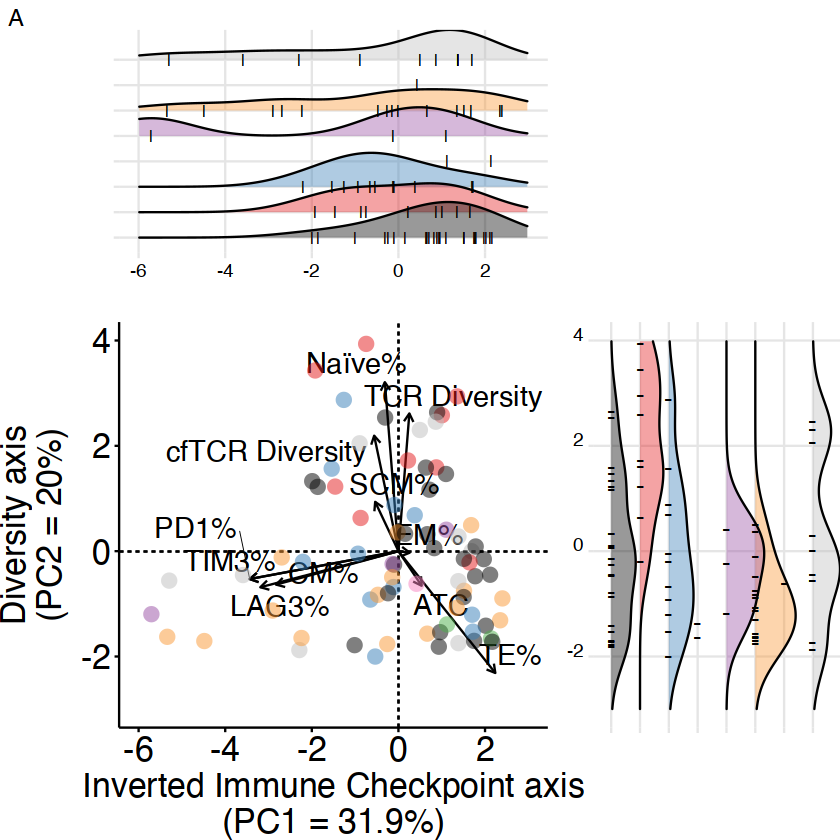

In [143]:
# Create aligned plot using cowplot
library(cowplot)

# Create the combined plot with proper alignment
combined_plot <- plot_grid(
  ridge_x + theme(axis.title.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), "cm")),NULL, NULL, 
  NULL, NULL, NULL, 
  p3 + theme(legend.position = "none",plot.margin = unit(c(0, 0, 0, 0), "cm")),
  NULL,
  ridge_y + theme(axis.title.y = element_blank(), plot.margin = unit(c(0, 0, 0, 0), "cm")),

  ncol = 3, nrow = 3,
  align = "hv",
  rel_widths = c(1.5, -0.2,1),
  rel_heights = c(1, -0.2,1.5),
  labels = "A"
)

# # Save the combined plot
pdf(paste0(plotpath,"pca_regimen_ridgeplot_cowplot.pdf"), width = 10, height = 8)
combined_plot
dev.off()

# Display the plot
combined_plot
